In [193]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [107]:
import os
from graphviz import Digraph

# Add the path where Graphviz is installed
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

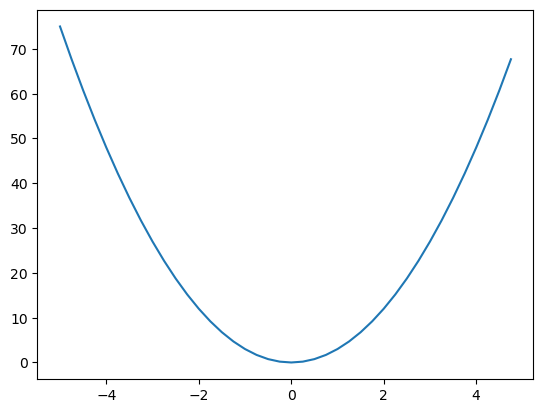

In [109]:
def f(x):
    return 3*x**2

x = np.arange(-5,5,0.25)
y=f(x)
plt.plot(x,y)

The above function created has a quadratic form as shown.
Slopes/ Derivatives are essentially quantities that tell us how the 'y' changes as we nudge 'x'
nudging by a small amount h
(f(x+h) - f(x))/h = slope

In [112]:
h = 0.0001
a = -3.0
b = 2
c = 4
d=a*b+2*c
d

2.0

In [114]:
a+=h
d2 = a*b+2*c
d2

2.0002000000000004

In [116]:
(d2-d)/h

2.0000000000042206

slope is 2 indeed, by calculus rules, we get dd/da = b, and b = 2

In [527]:
class Value:
    def __init__(self,data,_children=(),_op = '',label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        #since a + 1 should also be performed,(1 is not a Value obj)
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')

        def _backward():
            #in addition, x+y = v, z = f(v), dv/dx = 1 
            # by chain rule, dz/dx = (dz/dv) * (dv/dx)
            #Note : += is present for represenation of multiple ref of a variable
            # for ex: b = a* a
            self.grad += 1* out.grad
            other.grad += 1*out.grad
        out._backward = _backward
        return out
    def __radd__(self,other):
        return self + other
        
    def __sub__(self,other):
        out = self + (-other)
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),label='tanh')
        def _backward():
            # 1-tanh(x)**2
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
    
                        
        return out

    def exp(self):
        x = self.data
        out = Value( math.exp(x) , (self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    

    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')

        def _backward():
            # a*b = c , dc/da = b
            self.grad += other.data* out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self,other):
        # This is an alternative when mul cannot be done
        # for example, 2*a -> __mul__ in int does not know how to multiply int with a custom object, so rmul will be called: ValueObject as right operand

        return self*other


    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float"
        out = Value(self.data**other,(self,) ,f"**{other}")

        def _backward():
            # x^n differentiation is nx^(n-1)
            self.grad += other*(self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self,other):
        # division can be imagined as a/b = a* b**-1
        return self*(other**-1)

    

    
    def __neg__(self):
        return self * -1

    def backward(self):
        # to perform backpropogation, we need to topologically sort the nodes
        # such that current has all the required derivatives to perform itself
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    



In [529]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape="record")

        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [531]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label = 'x2')
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label='w2')

b=Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2+b ; n.label='n'

# now activation of the last node is done by using the tanh fn
o = n.tanh(); o.label = 'o'
o.backward()


print(d._prev," got by operation :",d._op)

{Value(data=10.0), Value(data=-6.0)}  got by operation : +


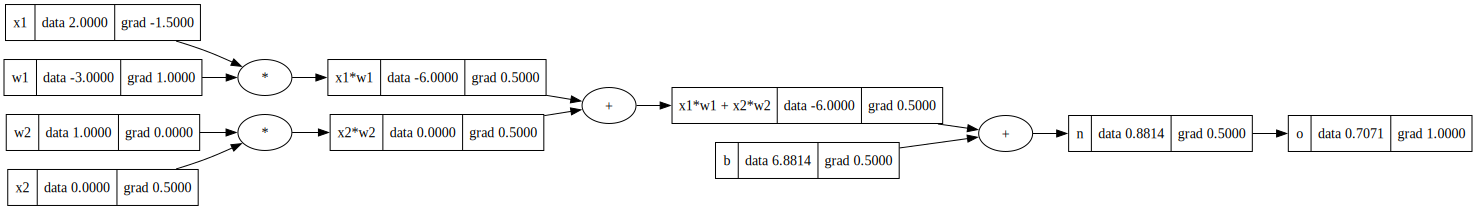

In [533]:
draw_dot(o)

The same, using pytorch will follow structure
pytorch works with tensors, ie array of elements and not a single element Value like in micrograd

it has functions like o.item 
it has attributes like o.grad, o._prev

In [535]:
import torch

In [538]:
x1 = torch.Tensor([2.0]).double() ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())




0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Now to work on a multitude of data at once, say a 3 layer neural network also called a multi-layer perceptron, we need to create neurons, layers and mlp



 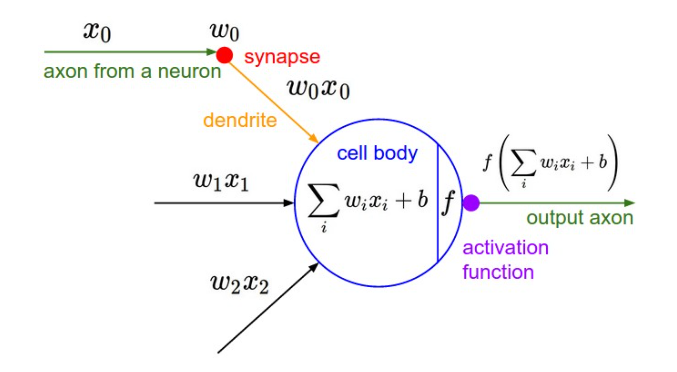

A neuron takes multiple weights as inputs, and has a self bias.
To create a layer of neurons: #neurons, #inputs are needed

A multi layer perceptron has:
    1 input layer
    1 or more hidden layers
    1 output layer


Note: we need to extract the paramters for performing gradient descent: nudging the weights and biases in the path of lower loss

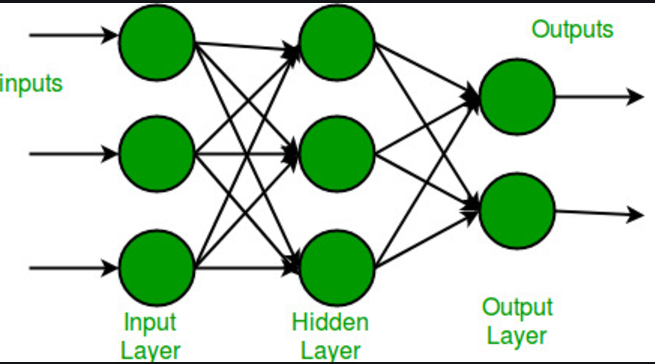

In [544]:
class Neuron:
    def __init__(self,nin):
        #initialising weights and bias
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w*x + b
        act = sum( (wi*xi for wi, xi in zip(self.w,x)), self.b )
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters()]
        

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        #[3,4,4,1] -> 3 inputs, 1st and 2nd hidden layer with 4 neurons, output layer with 1 neuron
        self.layers = [  Layer(sz[i],sz[i+1]) for i in range(len(nouts)) ]    

    def __call__(self, x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




    

In [546]:

n = Neuron(3)
n([1.0,2,0,-1.5])

Value(data=0.07628742045802402)

In [548]:
x = [2.0,3.0,-1.0]
nn = MLP(3,[4,4,1])
nn(x)

Value(data=-0.8643433395225255)

In [550]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [682]:
for k in range(20):
    
    ypred = [nn(x) for x in xs]
    #mean squared error as loss:
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in nn.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in nn.parameters():
        p.data+= (-0.1)*p.grad
    print(k,loss.data)




0 0.0003579968383109064
1 0.0003576433225973163
2 0.00035728901592052987
3 0.00035693690884455677
4 0.0003565848524814603
5 0.000356232974184382
6 0.0003558829068466678
7 0.0003555327264181863
8 0.00035518380429449853
9 0.00035483530456517426
10 0.00035448760738359113
11 0.00035414110573249316
12 0.0003537955045082086
13 0.0003534495558823677
14 0.00035310441770529204
15 0.0003527589056318023
16 0.0003524140883557522
17 0.00035206968931504015
18 0.0003517278378713929
19 0.00035138498374957713


In [684]:
ypred

[Value(data=0.9904525401590532),
 Value(data=-0.9910311558916094),
 Value(data=-0.9906194172667417),
 Value(data=0.9904190033253858)]